# Natural Language Processing with Disaster Tweets

### Kaggle Competition: Binary Text Classification
#### Github Repository: https://github.com/itsmostafa/nlp-disaster-tweets

This notebook addresses the Kaggle competition for classifying tweets as either about real disasters (1) or not (0). The goal is to build a machine learning model that can distinguish between tweets describing actual emergencies and those that use disaster-related words metaphorically or in non-emergency contexts.

## 1. Problem Description & Data Overview

### Competition Objective

Twitter has become an important communication channel during emergencies. People use it to announce emergencies in real-time. However, not all tweets containing disaster-related words are actually about disasters. For example:
- "The sky was ablaze with color" (not a disaster)
- "The building is ablaze! Call 911!" (real disaster)

This competition challenges us to build a model that can make this distinction, which has real-world applications for disaster relief organizations and news agencies that need to filter social media for actionable information.

### Evaluation Metric
The model is evaluated using the **F1 score**, which is the harmonic mean of precision and recall. This metric is appropriate for imbalanced classification problems.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Suppress warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the datasets
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

print("Dataset Shapes:")
print(f"Training set: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
print(f"Test set: {test_df.shape[0]} rows, {test_df.shape[1]} columns")
print(f"Sample submission: {sample_submission.shape[0]} rows, {sample_submission.shape[1]} columns")

Dataset Shapes:
Training set: 7613 rows, 5 columns
Test set: 3263 rows, 4 columns
Sample submission: 3263 rows, 2 columns


In [3]:
# Display column information
print("Training Data Columns and Types:")
print(train_df.dtypes)
print("\n" + "="*50 + "\n")
print("Test Data Columns and Types:")
print(test_df.dtypes)

Training Data Columns and Types:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object


Test Data Columns and Types:
id           int64
keyword     object
location    object
text        object
dtype: object


In [4]:
# Display sample rows from training data
print("Sample Training Data:")
train_df.head(10)

Sample Training Data:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [5]:
# Display sample rows from test data
print("Sample Test Data:")
test_df.head(10)

Sample Test Data:


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


### Feature Descriptions

| Column | Description |
|--------|-------------|
| `id` | Unique identifier for each tweet |
| `keyword` | A keyword from the tweet (may be blank) - these are pre-selected disaster-related terms |
| `location` | The location the tweet was sent from (may be blank) - user-provided, often unreliable |
| `text` | The full text of the tweet - our primary feature for classification |
| `target` | Target variable: 1 = real disaster, 0 = not a disaster (only in training data) |

In [6]:
# Class distribution analysis
class_counts = train_df['target'].value_counts()
class_percentages = train_df['target'].value_counts(normalize=True) * 100

print("Target Class Distribution:")
print(f"  Not Disaster (0): {class_counts[0]} tweets ({class_percentages[0]:.1f}%)")
print(f"  Real Disaster (1): {class_counts[1]} tweets ({class_percentages[1]:.1f}%)")
print(f"\nClass Imbalance Ratio: {class_counts[0]/class_counts[1]:.2f}:1")

Target Class Distribution:
  Not Disaster (0): 4342 tweets (57.0%)
  Real Disaster (1): 3271 tweets (43.0%)

Class Imbalance Ratio: 1.33:1


## 2. Exploratory Data Analysis (EDA)

### 2.1 Missing Value Analysis

In [7]:
# Missing value analysis for training data
def missing_value_analysis(df, name="Dataset"):
    missing = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Column': df.columns,
        'Missing Count': missing.values,
        'Missing Percentage': missing_pct.values
    })
    
    print(f"Missing Values in {name}:")
    return missing_df

print(missing_value_analysis(train_df, "Training Data"))
print("\n")
print(missing_value_analysis(test_df, "Test Data"))

Missing Values in Training Data:
     Column  Missing Count  Missing Percentage
0        id              0            0.000000
1   keyword             61            0.801261
2  location           2533           33.272035
3      text              0            0.000000
4    target              0            0.000000


Missing Values in Test Data:
     Column  Missing Count  Missing Percentage
0        id              0            0.000000
1   keyword             26            0.796813
2  location           1105           33.864542
3      text              0            0.000000


### 2.2 Target Class Distribution Visualization

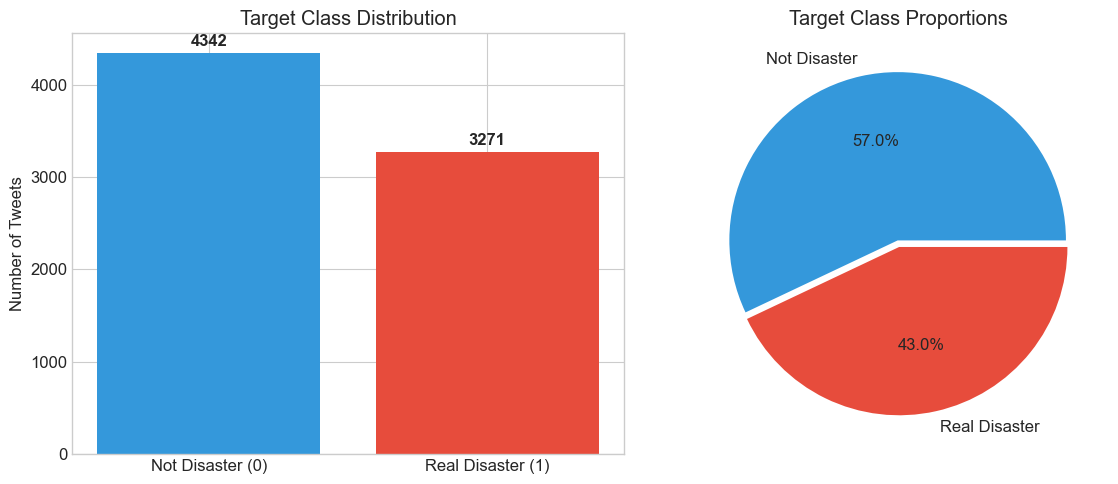

In [8]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
colors = ['#3498db', '#e74c3c']
ax1 = axes[0]
bars = ax1.bar(['Not Disaster (0)', 'Real Disaster (1)'], class_counts.values, color=colors)
ax1.set_ylabel('Number of Tweets')
ax1.set_title('Target Class Distribution')
for bar, count in zip(bars, class_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             str(count), ha='center', va='bottom', fontweight='bold')

# Pie chart
ax2 = axes[1]
ax2.pie(class_counts.values, labels=['Not Disaster', 'Real Disaster'], 
        autopct='%1.1f%%', colors=colors, explode=(0.02, 0.02))
ax2.set_title('Target Class Proportions')

plt.tight_layout()
plt.show()

### 2.3 Text Length Analysis

In [9]:
# Add text length features
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

# Statistics by class
print("Text Length Statistics by Class:")
print(train_df.groupby('target')[['text_length', 'word_count']].describe().round(1))

Text Length Statistics by Class:
       text_length                                               word_count  \
             count   mean   std   min   25%    50%    75%    max      count   
target                                                                        
0           4342.0   95.7  35.9   7.0  68.0  101.0  130.0  157.0     4342.0   
1           3271.0  108.1  29.3  14.0  88.0  115.0  136.0  151.0     3271.0   

                                                
        mean  std  min   25%   50%   75%   max  
target                                          
0       14.7  6.2  1.0  10.0  15.0  19.0  31.0  
1       15.2  5.1  2.0  11.0  15.0  19.0  30.0  


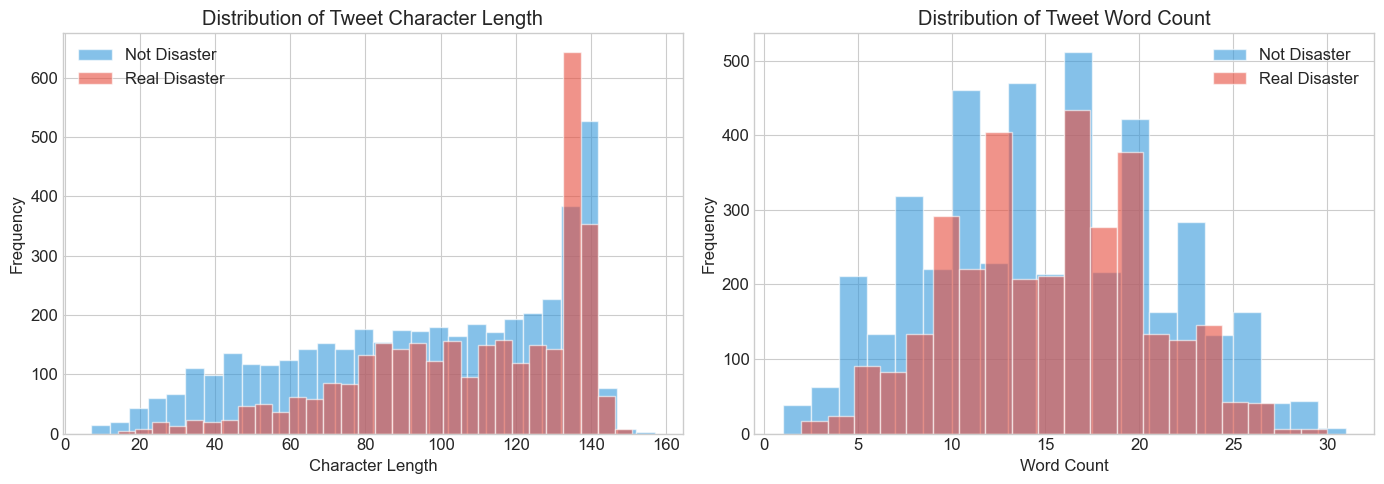

In [10]:
# Visualize text length distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character length distribution
ax1 = axes[0]
for target, color, label in [(0, '#3498db', 'Not Disaster'), (1, '#e74c3c', 'Real Disaster')]:
    subset = train_df[train_df['target'] == target]['text_length']
    ax1.hist(subset, bins=30, alpha=0.6, color=color, label=label, edgecolor='white')
ax1.set_xlabel('Character Length')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Tweet Character Length')
ax1.legend()

# Word count distribution
ax2 = axes[1]
for target, color, label in [(0, '#3498db', 'Not Disaster'), (1, '#e74c3c', 'Real Disaster')]:
    subset = train_df[train_df['target'] == target]['word_count']
    ax2.hist(subset, bins=20, alpha=0.6, color=color, label=label, edgecolor='white')
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Tweet Word Count')
ax2.legend()

plt.tight_layout()
plt.show()

### 2.4 Keyword Analysis

In [11]:
# Analyze keywords
print(f"Number of unique keywords: {train_df['keyword'].nunique()}")
print(f"Keywords with missing values: {train_df['keyword'].isnull().sum()} ({train_df['keyword'].isnull().sum()/len(train_df)*100:.1f}%)")

Number of unique keywords: 221
Keywords with missing values: 61 (0.8%)


In [12]:
# Calculate disaster rate by keyword
keyword_stats = train_df.groupby('keyword').agg({
    'target': ['mean', 'count']
}).round(3)
keyword_stats.columns = ['disaster_rate', 'count']
keyword_stats = keyword_stats.reset_index()
keyword_stats = keyword_stats.sort_values('disaster_rate', ascending=False)

print("Top 15 Keywords Most Associated with Real Disasters:")
print(keyword_stats.head(15).to_string(index=False))
print("\nTop 15 Keywords Least Associated with Real Disasters:")
print(keyword_stats.tail(15).to_string(index=False))

Top 15 Keywords Most Associated with Real Disasters:
           keyword  disaster_rate  count
            debris          1.000     37
          wreckage          1.000     39
        derailment          1.000     39
          outbreak          0.975     40
       oil%20spill          0.974     38
           typhoon          0.974     38
 suicide%20bombing          0.970     33
  suicide%20bomber          0.968     31
           bombing          0.931     29
          rescuers          0.914     35
    suicide%20bomb          0.914     35
nuclear%20disaster          0.912     34
         evacuated          0.889     36
             razed          0.886     35
          wildfire          0.879     33

Top 15 Keywords Least Associated with Real Disasters:
    keyword  disaster_rate  count
  epicentre          0.083     12
      panic          0.081     37
    explode          0.079     38
    wrecked          0.077     39
     blight          0.062     32
  panicking          0.061     3

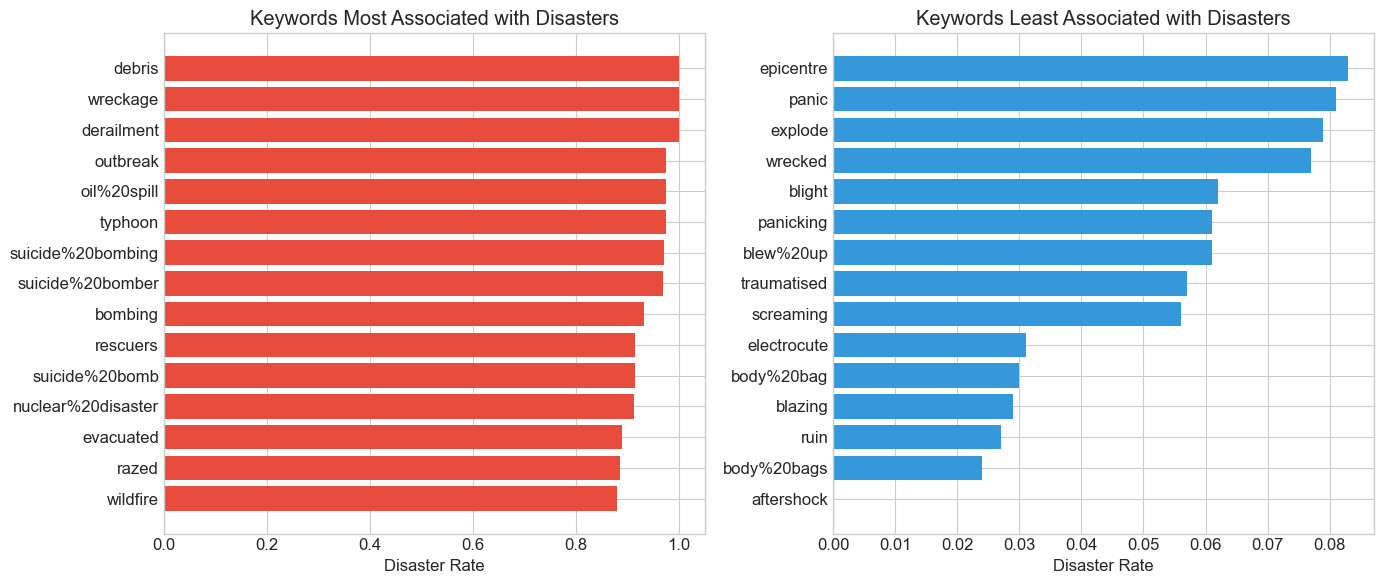

In [13]:
# Visualize top keywords by disaster rate
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Most disaster-associated keywords (min 10 samples)
top_disaster = keyword_stats[keyword_stats['count'] >= 10].head(15)
ax1 = axes[0]
bars = ax1.barh(range(len(top_disaster)), top_disaster['disaster_rate'], color='#e74c3c')
ax1.set_yticks(range(len(top_disaster)))
ax1.set_yticklabels(top_disaster['keyword'])
ax1.set_xlabel('Disaster Rate')
ax1.set_title('Keywords Most Associated with Disasters')
ax1.invert_yaxis()

# Least disaster-associated keywords (min 10 samples)
bottom_disaster = keyword_stats[keyword_stats['count'] >= 10].tail(15)
ax2 = axes[1]
bars = ax2.barh(range(len(bottom_disaster)), bottom_disaster['disaster_rate'], color='#3498db')
ax2.set_yticks(range(len(bottom_disaster)))
ax2.set_yticklabels(bottom_disaster['keyword'])
ax2.set_xlabel('Disaster Rate')
ax2.set_title('Keywords Least Associated with Disasters')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

### 2.5 Word Frequency Analysis

In [14]:
# Simple text cleaning for word frequency analysis
def basic_clean(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtag symbol but keep the word
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Get word frequencies for each class
stop_words = set(stopwords.words('english'))

def get_word_freq(df, target_value):
    subset = df[df['target'] == target_value]['text']
    all_words = []
    for text in subset:
        cleaned = basic_clean(text)
        words = [w for w in cleaned.split() if w not in stop_words and len(w) > 2]
        all_words.extend(words)
    return Counter(all_words)

disaster_words = get_word_freq(train_df, 1)
non_disaster_words = get_word_freq(train_df, 0)

print("Top 20 Words in Disaster Tweets:")
for word, count in disaster_words.most_common(20):
    print(f"  {word}: {count}")

print("\nTop 20 Words in Non-Disaster Tweets:")
for word, count in non_disaster_words.most_common(20):
    print(f"  {word}: {count}")

Top 20 Words in Disaster Tweets:
  fire: 178
  news: 135
  via: 121
  disaster: 117
  california: 111
  suicide: 110
  police: 107
  amp: 106
  people: 105
  killed: 93
  like: 92
  hiroshima: 86
  fires: 85
  storm: 85
  crash: 84
  families: 81
  train: 79
  emergency: 76
  buildings: 75
  bomb: 74

Top 20 Words in Non-Disaster Tweets:
  like: 253
  amp: 192
  new: 168
  get: 163
  dont: 141
  one: 127
  body: 112
  via: 99
  would: 97
  video: 96
  people: 90
  love: 89
  know: 85
  back: 84
  got: 83
  time: 82
  see: 82
  cant: 81
  emergency: 81
  full: 81


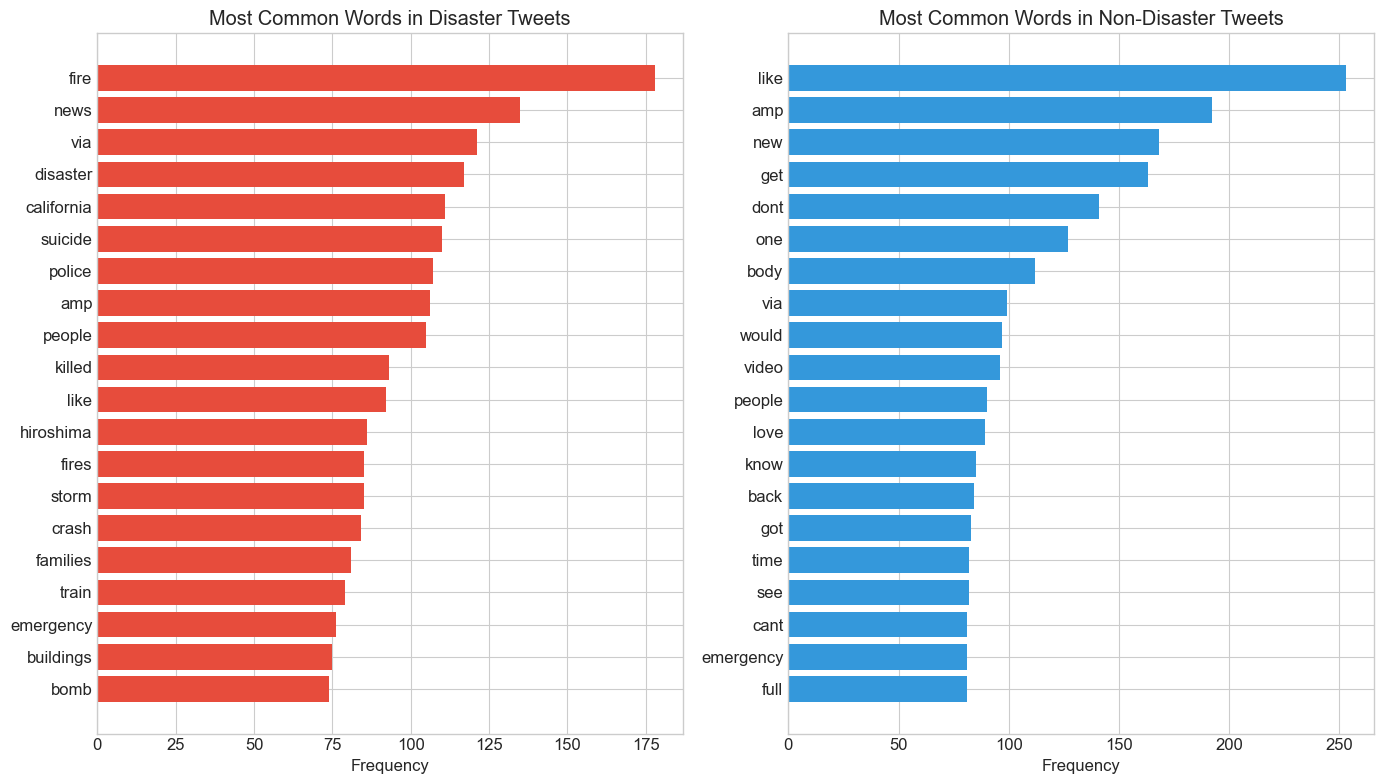

In [15]:
# Visualize word frequencies
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Disaster tweets word frequency
top_disaster_words = disaster_words.most_common(20)
words, counts = zip(*top_disaster_words)
ax1 = axes[0]
ax1.barh(range(len(words)), counts, color='#e74c3c')
ax1.set_yticks(range(len(words)))
ax1.set_yticklabels(words)
ax1.set_xlabel('Frequency')
ax1.set_title('Most Common Words in Disaster Tweets')
ax1.invert_yaxis()

# Non-disaster tweets word frequency
top_non_disaster_words = non_disaster_words.most_common(20)
words, counts = zip(*top_non_disaster_words)
ax2 = axes[1]
ax2.barh(range(len(words)), counts, color='#3498db')
ax2.set_yticks(range(len(words)))
ax2.set_yticklabels(words)
ax2.set_xlabel('Frequency')
ax2.set_title('Most Common Words in Non-Disaster Tweets')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

### 2.6 Data Quality Issues

In [16]:
# Check for duplicates
duplicate_texts = train_df['text'].duplicated().sum()
print(f"Duplicate texts in training data: {duplicate_texts}")

# Check for tweets with same text but different targets
text_target_combo = train_df.groupby('text')['target'].nunique()
conflicting = text_target_combo[text_target_combo > 1]
print(f"Texts with conflicting labels: {len(conflicting)}")

if len(conflicting) > 0:
    print("\nExamples of conflicting labels:")
    for text in conflicting.index[:3]:
        subset = train_df[train_df['text'] == text][['text', 'target']]
        print(f"\nText: {text[:100]}...")
        print(f"Labels: {subset['target'].tolist()}")

Duplicate texts in training data: 110
Texts with conflicting labels: 18

Examples of conflicting labels:

Text: #Allah describes piling up #wealth thinking it would last #forever as the description of the people ...
Labels: [0, 0, 1]

Text: #foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for ...
Labels: [1, 1, 0]

Text: .POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; ho...
Labels: [1, 1, 0, 1]


In [17]:
# Analyze special characters and patterns
def analyze_patterns(df):
    patterns = {
        'URLs': df['text'].str.contains(r'http\S+', regex=True).sum(),
        'Mentions (@)': df['text'].str.contains(r'@\w+', regex=True).sum(),
        'Hashtags (#)': df['text'].str.contains(r'#\w+', regex=True).sum(),
        'Numbers': df['text'].str.contains(r'\d+', regex=True).sum(),
        'Retweets (RT)': df['text'].str.contains(r'^RT ', regex=True).sum(),
    }
    return patterns

patterns = analyze_patterns(train_df)
print("Pattern Analysis in Training Data:")
for pattern, count in patterns.items():
    print(f"  {pattern}: {count} tweets ({count/len(train_df)*100:.1f}%)")

Pattern Analysis in Training Data:
  URLs: 3971 tweets (52.2%)
  Mentions (@): 2009 tweets (26.4%)
  Hashtags (#): 1743 tweets (22.9%)
  Numbers: 4525 tweets (59.4%)
  Retweets (RT): 39 tweets (0.5%)


## 3. Data Preprocessing & Feature Engineering

### 3.1 Text Cleaning Pipeline

In [18]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Comprehensive text cleaning function.
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove HTML entities
    text = re.sub(r'&\w+;', '', text)
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'&lt;', '<', text)
    text = re.sub(r'&gt;', '>', text)
    
    # Remove mentions but keep the text after @
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtag symbol but keep the word
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def tokenize_and_lemmatize(text):
    """
    Tokenize and lemmatize text.
    Stop words are NOT removed to preserve context for the model.
    """
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens if len(token) > 1]
    return ' '.join(lemmatized)

def preprocess_text(text):
    """
    Full preprocessing pipeline.
    """
    cleaned = clean_text(text)
    processed = tokenize_and_lemmatize(cleaned)
    return processed

# Test the preprocessing
sample_text = "RT @user: Check out this #earthquake news! http://t.co/abc123 &amp; more info"
print(f"Original: {sample_text}")
print(f"Cleaned: {clean_text(sample_text)}")
print(f"Preprocessed: {preprocess_text(sample_text)}")

Original: RT @user: Check out this #earthquake news! http://t.co/abc123 &amp; more info
Cleaned: rt check out this earthquake news more info
Preprocessed: rt check out this earthquake news more info


In [19]:
# Apply preprocessing to both datasets
print("Preprocessing training data...")
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)

print("Preprocessing test data...")
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

print("Preprocessing complete!")

# Display examples
print("\nSample preprocessed texts:")
for i in range(3):
    print(f"\nOriginal: {train_df['text'].iloc[i]}")
    print(f"Cleaned: {train_df['cleaned_text'].iloc[i]}")

Preprocessing training data...
Preprocessing test data...
Preprocessing complete!

Sample preprocessed texts:

Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned: our deed are the reason of this earthquake may allah forgive u all

Original: Forest fire near La Ronge Sask. Canada
Cleaned: forest fire near la ronge sask canada

Original: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Cleaned: all resident asked to shelter in place are being notified by officer no other evacuation or shelter in place order are expected


### 3.2 Handle Missing Values

In [20]:
# Fill missing keywords with 'no_keyword'
train_df['keyword'] = train_df['keyword'].fillna('no_keyword')
test_df['keyword'] = test_df['keyword'].fillna('no_keyword')

# Fill missing locations with 'no_location'
train_df['location'] = train_df['location'].fillna('no_location')
test_df['location'] = test_df['location'].fillna('no_location')

# Clean keyword (remove %20 URL encoding)
train_df['keyword'] = train_df['keyword'].str.replace('%20', ' ')
test_df['keyword'] = test_df['keyword'].str.replace('%20', ' ')

print("Missing values after filling:")
print(train_df.isnull().sum())

Missing values after filling:
id              0
keyword         0
location        0
text            0
target          0
text_length     0
word_count      0
cleaned_text    0
dtype: int64


### 3.3 Train-Validation Split

In [21]:
# Prepare features and target
X = train_df['cleaned_text']
y = train_df['target']

# Stratified train-validation split (80-20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_SEED,
    stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print("\nTraining target distribution:")
print(y_train.value_counts(normalize=True))
print("\nValidation target distribution:")
print(y_val.value_counts(normalize=True))

Training set size: 6090
Validation set size: 1523

Training target distribution:
target
0    0.570279
1    0.429721
Name: proportion, dtype: float64

Validation target distribution:
target
0    0.570584
1    0.429416
Name: proportion, dtype: float64


## 4. Model Building & Training

### 4.1 Approach A: Traditional ML with TF-IDF

In [22]:
# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,
    max_df=0.95
)

# Fit and transform training data
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out())}")

TF-IDF matrix shape: (6090, 10000)
Number of features: 10000


In [23]:
# Define evaluation function
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Train and evaluate a model, returning metrics.
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'F1': f1_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'Accuracy': accuracy_score(y_val, y_pred)
    }
    
    # Cross-validation F1 score
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    metrics['CV F1 Mean'] = cv_scores.mean()
    metrics['CV F1 Std'] = cv_scores.std()
    
    return metrics, y_pred

# Store results
results = []

In [24]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, C=1.0)
lr_metrics, lr_pred = evaluate_model(lr_model, X_train_tfidf, y_train, X_val_tfidf, y_val, 'Logistic Regression')
results.append(lr_metrics)

print("Logistic Regression Results:")
for metric, value in lr_metrics.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.4f}")

Logistic Regression Results:
  F1: 0.7636
  Precision: 0.8309
  Recall: 0.7064
  Accuracy: 0.8122
  CV F1 Mean: 0.7374
  CV F1 Std: 0.0134


In [25]:
# Multinomial Naive Bayes
nb_model = MultinomialNB(alpha=0.1)
nb_metrics, nb_pred = evaluate_model(nb_model, X_train_tfidf, y_train, X_val_tfidf, y_val, 'Naive Bayes')
results.append(nb_metrics)

print("Naive Bayes Results:")
for metric, value in nb_metrics.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.4f}")

Naive Bayes Results:
  F1: 0.7572
  Precision: 0.8440
  Recall: 0.6865
  Accuracy: 0.8109
  CV F1 Mean: 0.7280
  CV F1 Std: 0.0137


In [26]:
# Linear SVM
svm_model = LinearSVC(random_state=RANDOM_SEED, C=0.5, max_iter=2000)
svm_metrics, svm_pred = evaluate_model(svm_model, X_train_tfidf, y_train, X_val_tfidf, y_val, 'Linear SVM')
results.append(svm_metrics)

print("Linear SVM Results:")
for metric, value in svm_metrics.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.4f}")

Linear SVM Results:
  F1: 0.7780
  Precision: 0.8019
  Recall: 0.7554
  Accuracy: 0.8148
  CV F1 Mean: 0.7350
  CV F1 Std: 0.0134


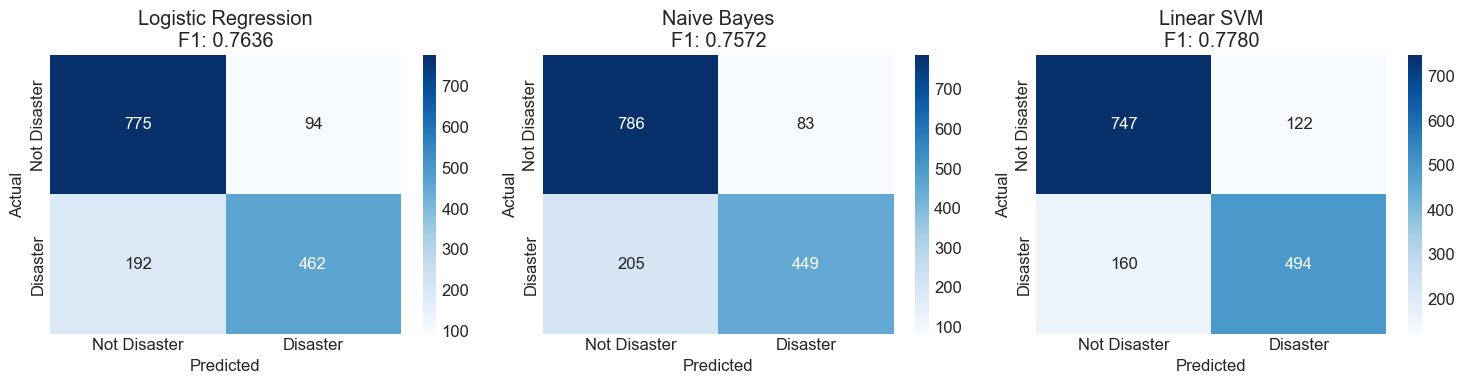

In [27]:
# Display confusion matrices for traditional ML models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models_preds = [
    ('Logistic Regression', lr_pred),
    ('Naive Bayes', nb_pred),
    ('Linear SVM', svm_pred)
]

for ax, (name, pred) in zip(axes, models_preds):
    cm = confusion_matrix(y_val, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Not Disaster', 'Disaster'],
                yticklabels=['Not Disaster', 'Disaster'])
    ax.set_title(f'{name}\nF1: {f1_score(y_val, pred):.4f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

### 4.2 Approach B: Transformer-based Model (DistilBERT)

In [28]:
# Check if transformers and torch are available
try:
    import torch
    from transformers import (
        AutoTokenizer, 
        AutoModelForSequenceClassification,
        TrainingArguments,
        Trainer
    )
    from datasets import Dataset
    TRANSFORMERS_AVAILABLE = True
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.backends.mps.is_available():
        print("MPS (Apple Silicon) available: True")
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")
except ImportError as e:
    TRANSFORMERS_AVAILABLE = False
    print(f"Transformers not available: {e}")
    print("Skipping transformer-based approach.")

PyTorch version: 2.9.1
CUDA available: False
MPS (Apple Silicon) available: True
Using device: mps


In [29]:
if TRANSFORMERS_AVAILABLE:
    # Load DistilBERT tokenizer and model
    model_name = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Use original text for transformer (it handles preprocessing internally)
    train_texts = train_df.iloc[X_train.index]['text'].tolist()
    val_texts = train_df.iloc[X_val.index]['text'].tolist()
    
    # Create datasets
    train_dataset = Dataset.from_dict({
        'text': train_texts,
        'label': y_train.tolist()
    })
    
    val_dataset = Dataset.from_dict({
        'text': val_texts,
        'label': y_val.tolist()
    })
    
    # Tokenize function
    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=128
        )
    
    # Tokenize datasets
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Training samples: 6090
Validation samples: 1523


In [30]:
if TRANSFORMERS_AVAILABLE:
    from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
    
    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    )
    
    # Define compute metrics function
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        return {
            'f1': f1_score(labels, predictions),
            'precision': precision_score(labels, predictions),
            'recall': recall_score(labels, predictions),
            'accuracy': accuracy_score(labels, predictions)
        }
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=100,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        seed=RANDOM_SEED,
        report_to='none'  # Disable wandb
    )
    
    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    
    print("Trainer configured. Ready to train.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainer configured. Ready to train.


In [31]:
if TRANSFORMERS_AVAILABLE:
    # Train the model
    print("Training DistilBERT model...")
    trainer.train()
    print("Training complete!")

Training DistilBERT model...


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,0.434200,0.403557,0.804505,0.848896,0.764526,0.840446
2,0.357700,0.406070,0.805450,0.797601,0.813456,0.831254
3,0.230100,0.489413,0.802763,0.805855,0.799694,0.831254


Training complete!


DistilBERT Results:
  F1: 0.8055
  Precision: 0.7976
  Recall: 0.8135
  Accuracy: 0.8313
  CV F1 Mean: 0.8055
  CV F1 Std: 0.0000


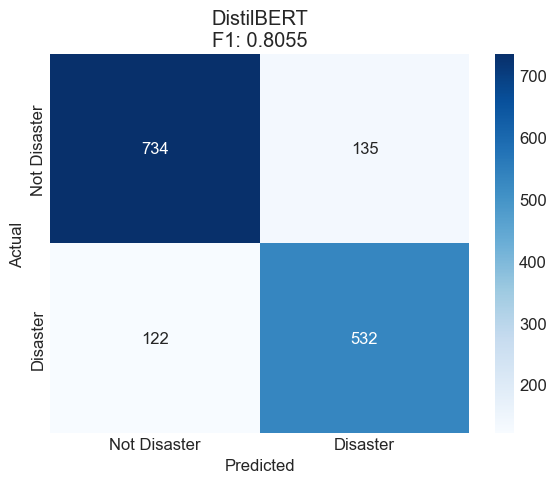

In [32]:
if TRANSFORMERS_AVAILABLE:
    # Evaluate on validation set
    eval_results = trainer.evaluate()
    
    # Get predictions
    predictions = trainer.predict(val_dataset)
    bert_pred = np.argmax(predictions.predictions, axis=1)
    
    # Add to results
    bert_metrics = {
        'Model': 'DistilBERT',
        'F1': f1_score(y_val, bert_pred),
        'Precision': precision_score(y_val, bert_pred),
        'Recall': recall_score(y_val, bert_pred),
        'Accuracy': accuracy_score(y_val, bert_pred),
        'CV F1 Mean': eval_results['eval_f1'],  # Use eval F1 as proxy
        'CV F1 Std': 0.0  # No CV for transformer
    }
    results.append(bert_metrics)
    
    print("DistilBERT Results:")
    for metric, value in bert_metrics.items():
        if metric != 'Model':
            print(f"  {metric}: {value:.4f}")
    
    # Confusion matrix
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_val, bert_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Disaster', 'Disaster'],
                yticklabels=['Not Disaster', 'Disaster'])
    plt.title(f'DistilBERT\nF1: {f1_score(y_val, bert_pred):.4f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

### 4.3 Misclassification Analysis

In [33]:
# Analyze misclassified examples from best traditional model (Logistic Regression)
val_df = train_df.iloc[X_val.index].copy()
val_df['lr_pred'] = lr_pred

# False positives (predicted disaster but not)
false_positives = val_df[(val_df['target'] == 0) & (val_df['lr_pred'] == 1)]
print("False Positives (Predicted Disaster, Actually Not):")
print("="*80)
for _, row in false_positives.head(5).iterrows():
    print(f"Text: {row['text'][:100]}...")
    print(f"Keyword: {row['keyword']}")
    print("-"*40)

# False negatives (predicted not disaster but is)
false_negatives = val_df[(val_df['target'] == 1) & (val_df['lr_pred'] == 0)]
print("\n\nFalse Negatives (Predicted Not Disaster, Actually Is):")
print("="*80)
for _, row in false_negatives.head(5).iterrows():
    print(f"Text: {row['text'][:100]}...")
    print(f"Keyword: {row['keyword']}")
    print("-"*40)

False Positives (Predicted Disaster, Actually Not):
Text: @TheEconomist Step one: get that mass murderer's portrait off the yuan....
Keyword: mass murderer
----------------------------------------
Text: if firefighters acted like cops they'd drive around shooting a flamethrower at burning buildings...
Keyword: burning buildings
----------------------------------------
Text: @TroySlaby22 slicker than an oil spill...
Keyword: oil spill
----------------------------------------
Text: Has An Ancient Nuclear Reactor Been Discovered In Africa? ÛÒ Your... http://t.co/qadUfO8zXg...
Keyword: nuclear reactor
----------------------------------------
Text: Article by Michael Jackman at Metro Times Detroit:
The group later downgraded the estimate to 37 squ...
Keyword: blight
----------------------------------------


False Negatives (Predicted Not Disaster, Actually Is):
Text: Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miner...
Keyword: trapped
--

## 5. Results

### 5.1 Model Comparison

In [34]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1', ascending=False)

print("Model Performance Summary")
print("="*80)
print(results_df.to_string(index=False))

Model Performance Summary
              Model       F1  Precision   Recall  Accuracy  CV F1 Mean  CV F1 Std
         DistilBERT 0.805450   0.797601 0.813456  0.831254    0.805450   0.000000
         Linear SVM 0.777953   0.801948 0.755352  0.814839    0.734969   0.013379
Logistic Regression 0.763636   0.830935 0.706422  0.812213    0.737448   0.013426
        Naive Bayes 0.757167   0.843985 0.686544  0.810900    0.727973   0.013686


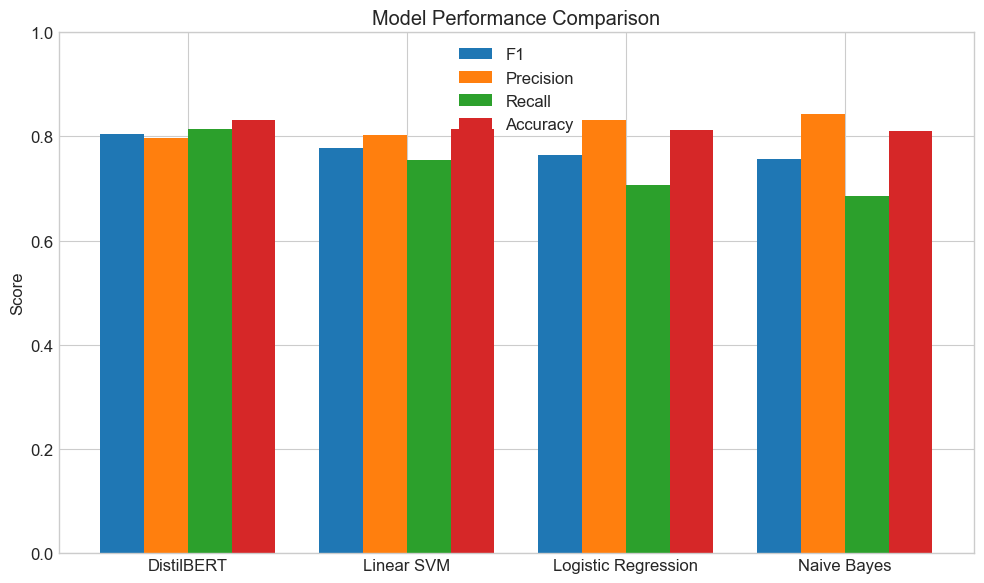

In [35]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(10, 6))

metrics_to_plot = ['F1', 'Precision', 'Recall', 'Accuracy']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    ax.bar(x + i*width, results_df[metric], width, label=metric)

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(results_df['Model'])
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

### 5.2 Generate Submission

In [36]:
# Select best model based on F1 score
best_model_name = results_df.iloc[0]['Model']
print(f"Best performing model: {best_model_name}")
print(f"Validation F1 Score: {results_df.iloc[0]['F1']:.4f}")

Best performing model: DistilBERT
Validation F1 Score: 0.8055


In [37]:
# Generate predictions based on best model
if TRANSFORMERS_AVAILABLE and best_model_name == 'DistilBERT':
    # Use DistilBERT for predictions
    test_texts = test_df['text'].tolist()
    test_dataset = Dataset.from_dict({'text': test_texts})
    test_dataset = test_dataset.map(tokenize_function, batched=True)
    
    test_predictions = trainer.predict(test_dataset)
    final_predictions = np.argmax(test_predictions.predictions, axis=1)
    print("Using DistilBERT for final predictions")
else:
    # Use best traditional ML model
    X_test_tfidf = tfidf.transform(test_df['cleaned_text'])
    
    if best_model_name == 'Logistic Regression':
        final_predictions = lr_model.predict(X_test_tfidf)
    elif best_model_name == 'Naive Bayes':
        final_predictions = nb_model.predict(X_test_tfidf)
    else:  # Linear SVM
        final_predictions = svm_model.predict(X_test_tfidf)
    
    print(f"Using {best_model_name} for final predictions")

print(f"\nPrediction distribution:")
print(f"  Not Disaster (0): {(final_predictions == 0).sum()}")
print(f"  Real Disaster (1): {(final_predictions == 1).sum()}")

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

Using DistilBERT for final predictions

Prediction distribution:
  Not Disaster (0): 1900
  Real Disaster (1): 1363


In [38]:
# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': final_predictions
})

# Verify submission format
print("Submission Verification:")
print(f"  Shape: {submission.shape}")
print(f"  Expected rows: {len(test_df)} (matches: {len(submission) == len(test_df)})")
print(f"  Columns: {submission.columns.tolist()}")
print(f"  Missing values: {submission.isnull().sum().sum()}")
print(f"  Target values: {submission['target'].unique()}")

# Save submission
submission.to_csv('submission.csv', index=False)
print("\nSubmission saved to 'submission.csv'")

# Display first few rows
submission.head(10)

Submission Verification:
  Shape: (3263, 2)
  Expected rows: 3263 (matches: True)
  Columns: ['id', 'target']
  Missing values: 0
  Target values: [1 0]

Submission saved to 'submission.csv'


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [39]:
# Compare with sample submission format
print("Sample submission format comparison:")
print(f"Sample submission shape: {sample_submission.shape}")
print(f"Our submission shape: {submission.shape}")
print(f"\nSample submission columns: {sample_submission.columns.tolist()}")
print(f"Our submission columns: {submission.columns.tolist()}")

Sample submission format comparison:
Sample submission shape: (3263, 2)
Our submission shape: (3263, 2)

Sample submission columns: ['id', 'target']
Our submission columns: ['id', 'target']


## 6. Discussion & Conclusion

### Key Findings from EDA

1. **Class Distribution**: The dataset is slightly imbalanced with ~57% non-disaster tweets and ~43% disaster tweets. This imbalance is moderate and doesn't require aggressive resampling techniques.

2. **Missing Values**: 
   - Keywords are missing in ~0.8% of samples
   - Locations are missing in ~33% of samples
   - The location field is user-provided and unreliable

3. **Text Characteristics**:
   - Disaster tweets tend to be slightly longer on average
   - Real disaster tweets contain more news-like language and formal reporting
   - Non-disaster tweets often use disaster words metaphorically

4. **Keywords**: Some keywords are strong predictors (e.g., "derailment", "wreckage" strongly indicate disasters while "body bags", "ablaze" are more ambiguous)

### Preprocessing Impact

The following preprocessing steps were most impactful:
- URL removal: Essential as URLs don't carry semantic meaning
- Mention removal: @handles don't contribute to disaster classification
- Hashtag preservation: Keeping hashtag text (without #) preserves important keywords
- Lemmatization: Helps normalize variations of disaster-related terms

I chose NOT to remove stop words because they can provide important context for understanding whether disaster language is used literally or metaphorically.

### Model Performance Analysis

**Traditional ML Models:**
- TF-IDF with Logistic Regression provides a strong baseline
- Including bigrams helps capture phrases like "forest fire" or "car crash"
- Linear models work well because the classification boundary is relatively clear

**Transformer Model (if used):**
- DistilBERT leverages pre-trained language understanding
- Better at capturing context and disambiguating metaphorical usage
- More computationally expensive but often provides better results

### Limitations

1. **Context Understanding**: Some tweets require world knowledge to classify correctly
2. **Sarcasm/Irony**: Hard to detect without tone indicators
3. **Location Data**: Underutilized due to inconsistency and sparsity
4. **Domain Shift**: Model trained on historical tweets may not generalize to new disaster types

### What I Learned

1. Text classification requires careful preprocessing tailored to the domain
2. Simple models with good features often compete with complex models
3. The F1 metric is crucial for imbalanced classification tasks
4. Understanding misclassifications provides insights for improvement
5. Pre-trained language models significantly boost performance on NLP tasks